In [1]:
%load_ext autoreload
%autoreload 2

In [42]:
!pip install scikit-learn

     |████████████████████████████████| 24.9 MB 6.4 MB/s eta 0:00:01     |███████████████████▊            | 15.3 MB 6.6 MB/s eta 0:00:02     |██████████████████████▊         | 17.6 MB 6.6 MB/s eta 0:00:02     |███████████████████████         | 18.0 MB 6.6 MB/s eta 0:00:02     |███████████████████████▌        | 18.3 MB 5.5 MB/s eta 0:00:02
     |████████████████████████████████| 303 kB 7.0 MB/s eta 0:00:01
     |████████████████████████████████| 27.3 MB 6.6 MB/s eta 0:00:01     |██████████████▍                 | 12.3 MB 7.4 MB/s eta 0:00:03     |██████████████████████▏         | 18.9 MB 4.1 MB/s eta 0:00:03     |████████████████████████████▏   | 24.0 MB 4.1 MB/s eta 0:00:01     |█████████████████████████████   | 24.7 MB 6.6 MB/s eta 0:00:01


In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from random import random, seed
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [24]:
seed(42)

In [93]:
def generate(start = 100, n_steps = 350):
    out = [start]
    val = start
    for _ in range(n_steps):
        step = 2*random() - 1
        val = val + step
        out.append(val)
        
    return out

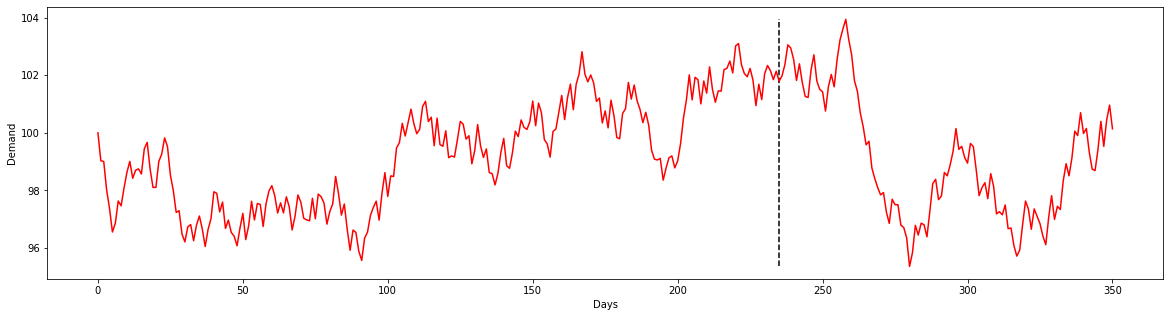

In [109]:
stocks = generate()

fig = plt.figure(figsize=(20,5))
plt.plot(stocks,'r-')
plt.vlines(int(0.67*len(stocks)),np.min(stocks),np.max(stocks),linestyles = '--',colors = 'k')
plt.xlabel('Days')
plt.ylabel('Demand');

In [110]:
training_set = pd.DataFrame(stocks)

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [111]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [112]:
num_epochs = 10000
learning_rate = 0.001

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 1000 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.07186
Epoch: 1000, loss: 0.00474
Epoch: 2000, loss: 0.00436
Epoch: 3000, loss: 0.00433
Epoch: 4000, loss: 0.00431
Epoch: 5000, loss: 0.00429
Epoch: 6000, loss: 0.00426
Epoch: 7000, loss: 0.00416
Epoch: 8000, loss: 0.00414
Epoch: 9000, loss: 0.00407


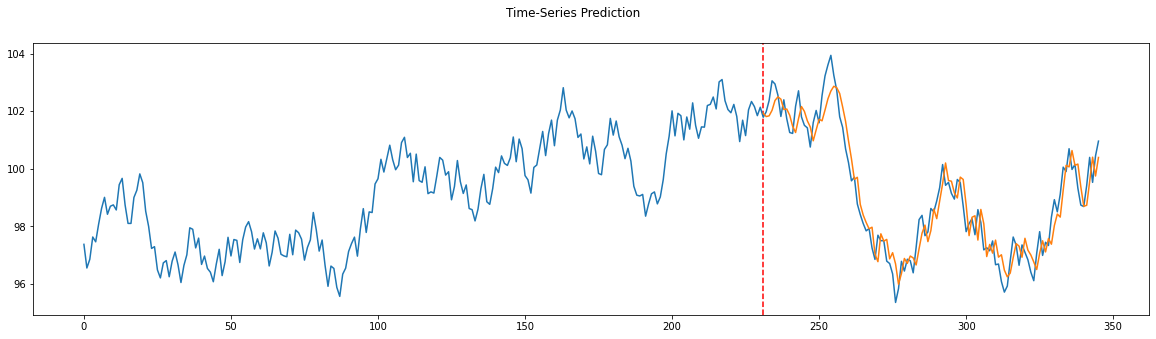

In [113]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize= (20,5))

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(range(231,len(data_predict)),data_predict[231:])
plt.suptitle('Time-Series Prediction')
plt.show()